In [1]:
import pandas as pd
from datetime import datetime
import numpy
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from collections import Counter
import re

After parsing data from websites using the web_scraper program, create dataframes from the resulting CSV files created from that program. The structure of the created CSVs are as follows

* Date
* Coin
* Website
* Text 
* Link

Since the "Text" column will be the main focal point of the data to extract sentiment, some preprocessing can be done to it while creating the Dataframe. Each website's articles contains certain sentences or phrases within them that bring no added value to the text. The sentences/phrases vary a little in writing and punctuation, but for the most part they are the same and can be removed from the text. 

e.g. in almost every Frobes article, there is a sentence:
> [Ed note: Investing in cryptocoins or tokens is highly speculative and the market is largely unregulated. Anyone considering it should be prepared to lose their entire investment.]

Every article has it's own unnecessary artifacts in them, so they will be removed in the panda making process



In [2]:
def make_a_panda():
    #################### Path Locations of all CSV files #####################
    csvForbes = 'Ripple_Forbes.csv'
    csvCNBC = 'Ripple_CNBC.csv'
    csvCointelegraph = 'Ripple_Cointelegraph.csv'
    csvCoindesk = 'Ripple_Coindesk.csv'
    csvBitcoin = 'Ripple_Bitcoin.csv'

    
    #################### Make Pandas DataFrames ##########################
    #FORBES
    dfForbes = pd.read_csv(csvForbes, encoding = 'utf-8', parse_dates = True)
    #Edit Forbes Text and remove unwanted sentence artifacts
    dfForbes.Text = dfForbes.Text.apply(lambda x: x.replace('[Ed note: Investing in cryptocoins or tokens is highly speculative and the market is largely unregulated. Anyone considering it should be prepared to lose their entire investment.]', ' '))
    dfForbes.Text = dfForbes.Text.apply(lambda x: x.replace('[Ed. note: Investing in cryptocoins or tokens is highly speculative and the market is largely unregulated. Anyone considering it should be prepared to lose their entire investment.',' '))
    dfForbes.Text = dfForbes.Text.apply(lambda x: x.replace('[Ed note: Investing in cryptocoins or tokens is highly speculative and the market is largely unregulated. Anyone considering it should be prepared to lose their entire investment.',' '))
    dfForbes.Text = dfForbes.Text.apply(lambda x: x.split('Editor’s Note & Disclosure:')[0])
    dfForbes.Text = dfForbes.Text.apply(lambda x: x.split('Editor’s Note and Disclosure:')[0])
    
    #CNBC
    dfCNBC = pd.read_csv(csvCNBC, encoding = 'utf-8', parse_dates = True)
    #Edit CNBC Text and remove unwanted sentence artifacts
    dfCNBC.Text = dfCNBC.Text.apply(lambda x: x.replace('Playing Share this video... Watch Next...',' '))

    #COINTELEGRAPH
    dfCointelegraph = pd.read_csv(csvCointelegraph, encoding = 'utf-8', parse_dates = True)
    #Edit Cointelegraph Text and remove unwanted sentence artifacts
    dfCointelegraph.Text = dfCointelegraph.Text.apply(lambda x: x.replace('Receive all Cointelegraph news immediately in Telegram.', ' '))
    dfCointelegraph.Text = dfCointelegraph.Text.apply(lambda x: x.replace('Price Analysis The views and opinions expressed here are solely those of authors/contributors and do not necessarily reflect the views of Cointelegraph.com. Every investment and trading move involves risk, you should conduct your own research when making a decision.',' '))
    dfCointelegraph.Text = dfCointelegraph.Text.apply(lambda x: x.replace('Price Analysis The views and opinions expressed here are solely those of authors/contributors and do not necessarily reflect the views of Cointelegraph.com. Every investment and trading move involves risk; you should conduct your own research when making a decision.',' '))
    dfCointelegraph.Text = dfCointelegraph.Text.apply(lambda x: x.replace('Price Analysis The views and opinions expressed here are solely those of the author and do not necessarily reflect the views of Cointelegraph.com. Every investment and trading move involves risk, you should conduct your own research when making a decision.',' '))
    dfCointelegraph.Text = dfCointelegraph.Text.apply(lambda x: x.replace('Follow us on Facebook  Follow us on Facebook Hide Comments  For updates and exclusive offers, enter your e-mail below.  Cointelegraph covers Fintech, Blockchain and Bitcoin bringing you the latest news and analyses on the future of money.   Thank you for contacting us! We will reply to you as soon as possible. Thank you for your interest in our franchise program. We are considering your request and will contact you in due course. If you have any further queries, please contact: franchise@cointelegraph.com',' '))
    
   
    #COINDESK
    dfCoindesk = pd.read_csv(csvCoindesk, encoding = 'utf-8', parse_dates = True)
    #Edit Coindesk Text and remove unwanted sentence artifacts
    dfCoindesk.Text = dfCoindesk.Text.apply(lambda x: x.split('Disclosure:')[0])
    dfCoindesk.Text = dfCoindesk.Text.apply(lambda x: x.split('Disclaimer:')[0])
    
    
    #BITCOIN
    dfBitcoin = pd.read_csv(csvBitcoin, encoding = 'utf-8', parse_dates = True)
    #Edit Bitcoin Text and remove unwanted sentence artifacts
    dfBitcoin.Text = dfBitcoin.Text.apply(lambda x: x.split('https:')[0])
    
    #Make a list of the DataFrames
    site = [dfForbes, dfCNBC, dfCointelegraph,dfCoindesk,dfBitcoin]
    
    #Concat the DataFrames into one
    df = pd.concat(site).reset_index()
    #Convert the date column from string to Pandas Datetime
    df.Date = pd.to_datetime(df.Date)

    # Replace \xa0 non-breaking space in Latin1 (ISO 8859-1) with unicode space u' ' in the Text column
    #this is an artifact put in the text during the encoding process while writing the articles to CSV 
    df.Text = df.Text.apply(lambda x: x.replace(u'\xa0', u' '))
    return df

The historical price data was data downloaded from the website [Coinmarketcap](https://coinmarketcap.com/currencies/bitcoin/historical-data/) in CSV format and is pretty straight forward in reading it to a pandas dataframe. Only a little processing has to be done with this data since it is already cleaned before downloading. 

In [3]:
def money_money_money(csv, coin = 'XRP'):
    #DataFrame of Pricing Data
    df = pd.read_csv(csv)
    #Convert string dates to datetime dates
    df.Date = pd.to_datetime(df.Date)
    #remove the last 2 rows of the dataframe - Junk data
    df = df.iloc[:-2]
    #remove the comma in the price data
    df.Price = df.Price.str.replace(',','')
    df.Open = df.Open.str.replace(',','')
    df.High = df.High.str.replace(',','')
    df.Low = df.Low.str.replace(',','')
    #convert columns from string to type Float
    df[['Price','Open','High','Low','Change %']] = df[['Price','Open','High','Low','Change %']].applymap(lambda x: float(x))
    df['Coin'] = coin
    df = df.set_index(['Date','Coin']).unstack().swaplevel(0,1,1).sort_index(1)
    return df

# Performing Sentiment Analysis

Sentiment analysis needs to be performed on the article text. A custom sentiment analysis class is built and used in facilitating the analysis process. This class accepts either a string of sentences representing the text or a list of sentences representing the text. Preprocessing of the text must be done before Sentiment Analysis can be performed. The most simple explanation of this processing is: **_Everything that provides little to no value to the ultimate meaning or sentiment of the text such as numbers, punctuations, stopwords, and symbols must be removed._** This class allows the user to invoke simple methods on the class object to perform this preprocessing.
> **NOTE:** There are a few out of the box libraries for performing sentiment analysis. There are two differnt libraries that exist in the class below
* Vader Sentiment
* TextBlob sentiment

>These libraries are included in the class, but were ultimately not used as they did not perform well enough on the text of interest to be deemed acceptable. They still exist in the class in the event that they may be used in some other fashion if necessary



### The methods contained in this class and can be performed on the object are as follows
* **words_only()**

    This method will remove numbers, punctuation, or any element that is not a capital or lower case letter from the text
    
    
* **stemmed()**

    This method will perform the act of word stemming. Stemming algorithms work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found in an inflected word. The NLTK library has several stemming algorithms. The Lancaster, Porter, and Snowball stemmer are used in this method. Each word is ran through each stemmer and a list is compiled of the 3 results. From there, the result that appears the most frequent is the used stem. A sentiment_analysis object is returned of all the stemmed words
    
    
* **lemmatize()**

    This method will perform the act of word lemmatization. Lemmatization takes into consideration the morphological analysis of words. To do so, it is necessary to have detailed dictionaries which the algorithm can look through to link the form back to its lemma. NLTK library uses WordNetLemmatizer to perform this act and is incorporated in this method. Each word in a text is ran through WordNet and lemmatized, returning a new sentiment_analysis object of the lemmatized words
    
    
* **remove_stopwords()**

    This method will remove all stop words from the text. Stop words are extremely common words that add little to no value to the true meaning behind text. e.g. [is, of, how, etc.] A new sentiment_analysis object is returned with all stop words removed
    
    
* **darth_vader()**

    This method  utilizes the Vader sentiment library of NLTK and returns the overall sentiment the text. It returns the overall sentiment of the text in the form of:
    
    **_{'compound': xxx, 'neg': xxx, 'neu': xxx, 'pos': xxx}_**
    * compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.
    * positive sentiment: compound score >= 0.5
    * neutral sentiment: (compound score > -0.5) and (compound score < 0.5)
    * negative sentiment: compound score <= -0.5
    
  > Full documentation on Vader Sentiment can be seen here: [Vader](https://github.com/cjhutto/vaderSentiment#about-the-scoring)
    
    
* **blobbed()**

    This method utilizes the sentiment analysis algorithm of the TextBlob library. The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
    
 > Full documentation on TextBlob can be seen here: [TextBlob](http://textblob.readthedocs.io/en/dev/)
    
    
* **word_cloud()**

    This method will return a word cloud of the text analyzed. The word cloud will consist of the 200 most frequent words in the text with the size of the word directly correlated to its frequency

In [4]:
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

class sentiment_analysis:
    
    def __init__(self,text,headline = False):
        #INPUT -> Article Headline
        if headline is True:
            self.text = text.lower()
            self.blob = TextBlob(text.lower())
        #INPUT -> List of Sentences
        elif isinstance(text,list):
            self.sentences = [word.lower() for word in text]
        #INPUT -> String of Sentences
        else:
            self.text = text[:-1].lower()
            self.blob = TextBlob(text)
            
    def words_only(self):
        try:
            self.text = ' '.join(self.sentences)
            words_only = re.sub('[^A-Za-z]', ' ', self.text)
            return sentiment_analysis(words_only)
        except:    
            words_only = re.sub('[^A-Za-z]', ' ', self.text)
            return sentiment_analysis(words_only)
    
    def stemmed(self):
        words = self.text.split()
        lancaster = LancasterStemmer()
        porter = PorterStemmer()
        snowball = SnowballStemmer('english')

        stemmed_text = []
        for word in words:
            stems = [lancaster.stem(word), porter.stem(word), snowball.stem(word)]
            stemmed_word = max(set(stems), key=stems.count)
            stemmed_text.append(stemmed_word)
        return sentiment_analysis(' '.join(stemmed_text))
    
    def lemmatize(self):
        words = self.text.split()
        wordnet = WordNetLemmatizer()
        lem = [wordnet.lemmatize(word) for word in words]
        return sentiment_analysis(' '.join(lem))

        
    def remove_stopwords(self, remove_punc = False):
        #INPUT -> string of sentences or headline
        #OUTPUT -> string of sentences or headline with stopwords and/or punctuation removed
        if hasattr(self, 'text'):
            #if user wants punctuation removed in conjuction with removing stop words
            if remove_punc == True:
                self.remove_punctuation = [char for char in self.text if char not in string.punctuation]
                self.no_punctuation = ''.join(self.remove_punctuation)
                self.no_stopwords = [word for word in self.no_punctuation.split() if word.lower() not in stopwords.words('english')]
                return sentiment_analysis(' '.join(self.no_stopwords))
            #if user only wants to remove stop words
            else:
                word = nltk.word_tokenize(self.text)
                self.no_stopwords = [word for word in word if word not in set(stopwords.words('english'))]
                return sentiment_analysis(' '.join(self.no_stopwords))
            
        #INPUT -> list of sentences
        #OUTPUT -> list of sentences with stopwords and/or punctuation removed
        else:
            self.list_no_stopwords = []
            #if user wants punctuation removed in conjuction with removing stop words
            if remove_punc == True:
                for sentence in self.sentences:
                    self.remove_punctuation = [char for char in sentence if char not in string.punctuation]
                    self.no_punctuation = ''.join(self.remove_punctuation)
                    self.no_stopwords = [word for word in self.no_punctuation.split() if word.lower() not in stopwords.words('english')]
                    self.list_no_stopwords.append(' '.join(self.no_stopwords))
                return sentiment_analysis(self.list_no_stopwords)
            #if user only wants to rmove stop words
            else:
                for sentence in self.sentences:
                    word = nltk.word_tokenize(sentence)
                    self.no_stopwords = [word for word in word if word.lower() not in stopwords.words('english')]
                    self.list_no_stopwords.append(' '.join(self.no_stopwords))
                return sentiment_analysis(self.list_no_stopwords)
            

    def darth_vader(self):
        #INPUT -> list of sentences
        #OUPUT -> vader sentiment analysis for each sentence in the list
        try:
            sid = SentimentIntensityAnalyzer()
            self.vader_scores = [sid.polarity_scores(sentence) for sentence in self.sentences]
            return self.vader_scores
        #INPUT -> sentence string
        #OUTPUT -> vader sentiment analysis for the string
        except:
            sid = SentimentIntensityAnalyzer()
            self.vader_score = sid.polarity_scores(self.text)
            return self.vader_score
            
            
            
    def blobbed(self):
        #INPUT -> list of sentences
        #OUPUT -> TextBlob sentiment analysis for each sentence in the list
        try:
            blobbed_sentences = [TextBlob(sentence) for sentence in self.sentences]
            self.blob_scores = [sentence.sentiment for sentence in blobbed_sentences]
            return self.blob_scores
        #INPUT -> sentence string
        #OUTPUT -> TextBlob sentiment analysis for the string
        except:
            blobbed_headline = TextBlob(self.text)
            self.blob_score = blobbed_headline.sentiment
            return self.blob_score
            
            
            
    #INPUT -> string of sentences or a single sentence
    #OUTPUT -> word cloud composed of words from the string input
    def word_cloud(self):
        wordcloud = WordCloud(background_color = 'white',
                              max_words = 200,
                              max_font_size = 40,
                             scale = 3,
                             random_state = 1).generate(self.text)
        fig = plt.figure(figsize=(15,15))
        self.ax = plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()
        return self.ax


# Custom Sentiment Analysis Library
As stated earlier, the out of box libraries for sentiment analysis didn't perfrom very well on the cryptocurrency text. This will be demonstrated below. The failure to correctly characterize an article's text as negative or positive can be attributed to what is considered positive/negative in everyday speech compared to what is considered positive/negative in regards to cryptocurrency. For example:
>"The **_surging_** waves came **_shooting_** up over the sea wall and flooded the city. People were **_jumping_** in their cars to escape the **_danger_**. Eventually the flood came **_down_** and all was normal.

>"Bitcoin was **_surging_** to new heights today. It has been **_shooting_** up in price for the past month, **_jumping_** up higher than everyone's expectations. Even though it is on the rise, experts fear a bubble may burst, and the price is in **_danger_** of coming **_down_**"


Even though the same words are utilized in both sentences, they provide a totally different meaning/sentiment to the sentence. Surging, shooting, and jumping helped convey a negative sentiment in the first sentence. But when used in the context of cryptocurrency, they provide a positive connotation. For this exact reason, a custom dictionary of positive and negative sentiment words must be created. A random sample of both obviously negative and obviously positive articles were sampled. From each, a list of negative and list of positive keywords were extracted. This "cryptocurrency library" is then used to perform a sentiment analysis. These word libraries are text files contained in the current path.

# Custom Sentiment Analysis Algorithm
Now that we have our cryptocurrency sentiment libraries, we need an algorithm on how to use them. What makes a body of text positive or negative? We first need to make a few assumptions. A body of text is made up of sentences, so it is safe to assume that when there are more negative sentences than positive sentences, the text overall must be negative. The same can be said of the opposite. Conversely a sentence is made up of words, therefore it is safe to assume that when there are more negative words in a sentence than positive, the sentence overall must be negative. Using our cryptocurrency negative and positive libraries, we can simply compare the number of negative words to positive words in a sentence to get its sentiment. Then we can compare the number of negative sentences to positive in the text to get its overall sentiment. From this, not only can we assume the overall sentiment of the text, but also the strength of sentiment. From a higher percentage of negative sentences in a text, one can assume a stronger negative sentiment. Again, the same can be said of the opposite.

### A Few Things To consider
*******************
#### FIRST
* **It isn't enough to just say: <font color = 'red'>  _When [# of negative words > # of positve words] then sentence is negative_ </font> . Some sentences are more negative than others. To catch the strength of sentiment, we must also capture strength of positivty or negativity of each sentence. Let's take the following text for example:**
> Bitcoin is surging(+1) today after suffering(-1) losses(-1) all last week.
> The surge(+1) is umprompted as there have been no major developments out of the Bitcoin camp.
> Investors don't mind the sudden upswing(+1).
> Smart investors however know not to get too excited(+1) as the price will more than likey experience a negative(-1) correction(-1)
> Some experts believe that not only will the price drop(-1), but it will plummet(-1) to yearly lows(-1) leaving today's investors in a world of hurt(-1).


Analyzing sentence by sentence:
1. Sentence one: (+1) + (-1) + (-1) = -1
2. Setence two: (+1) = 1
3. Sentence three: (+1) = 1
4. Sentence four: (+1) + (-1) + (-1) = -1
5. Sentence five: (-1) + (-1) + (-1) + (-1) = -4

 

Adding up all sentence scores nets a grand total of **-4**. We could stop here and perform our sentiment analysis like this, but this wouldn't accurately model uneven text. For example what if the first sentence contained 10 negative keywords, and the rest of the sentences were positive, but only contained one positive keyword in each. That would net a score of (-10 + 4) = -6. This would violate our initial assumption that if there are more positive or negative sentences in a text, then that text must be positive or negative respectively.

#### SECOND

* **We must proportion each sentence score so that it reduces the effect of outliers. (outliers being those sentence with an unusual amount of keywords)**

The easiest way to do that is by:

1. Calculating the percentage of negative and positive sentences in the text
2. Summing the score of all negative sentences and summing the score of all positive sentences
3. Multiplying the score of all negative sentences by the percentage of negative sentences and the score of all positive sentences by the percentage of positive sentences

Again using the five sentences above; there were (3/5) negative sentences with a total negative point score of (-6) and (2/5) positive sentences with a total positive score of (2).

** Strength of negative sentiment = (3/5) x (-6) = -3.6**

** Strength of positive sentiment = (2/5) x (2) = 0.8**

This upon initial inspection seems reasonable. The overall sentiment of the text is strongly negative, and our sentiment score properly reflects that with a -3.6. Also, there are some light positive elements in the example text and they are represented by a light positive sentiment score. But how strong [or weak] is -3.6 compared to other texts? What is the maximum possible score on both ends of the spectrum? How will a strongly positive text with very few sentences score compare to a moderately positive text with dozens of sentences? These questions bring about the next step.

#### THREE

* **The scores must be properly normalized**

When writing an article, the author decides how strong or weak they want to make the article by placing more or less of the emphasis words (keywords) in the article. For conversation sake, let's say you are the author of the article above. Your editor has placed a 12 emphasis word limit on you. So in 12 words you must get as much positive and negative sentiment into the text that you want to convey. Therefore, in order to normalize the sentiment scores, we can divide them by the total number of emphasis words in the text

** Strength of negative sentiment = (-3.6) / 12 = -0.3**

** Strength of positive sentiment = (0.8) / 12 = 0.06**

When strength of positive sentiment (S.P.S) is closer to +1, the stronger the positive sentiment. Conversely, when strength of negative sentiment (S.N.S) is closer to -1, the stronger the negative sentiment The closer to zero either number is, that represents a lesser amount of positive/negative sentiment in the text. When the two numbers are close to equal (but opposite) then the text can be deemed neutral overall. e.g. S.P.S = 0.42 & S.N.S = -0.48 the article is neutral



In [38]:
from collections import namedtuple
Sentiment = namedtuple('Sentiment', ['Strength_of_Positivity', 'Strength_of_Negativity'])

#Load the negative cryptocurrency word library
with open('negative.txt') as fh:
    file = fh.readlines()
    negatives = [line.strip() for line in file]
    
#load the positive cryptocurrency word library    
with open('positive.txt') as fh:
    file = fh.readlines()
    positives = [line.strip() for line in file]   


########### Custom Sentiment Analysis 
def coin_sentiment(text, headline = False):
    #Create sentiment_analysis object with text
    text = sentiment_analysis(text)
    
    #Initialize dictionary to keep track of sentence statistics
    sentence_tracker = {'neg':{'score':0, 'sentences':0},
                    'pos':{'score':0, 'sentences':0},
                    'neu':{'sentences':0}}

    #Break the text into individual sentences and loop through each sentence
    for sent in text.blob.sentences:
        #Remove all punctuation and numbers then split the sentence into individual words
        words = sentiment_analysis(str(sent)).words_only().text.split()
        
        neg = 0
        pos = 0
        #Loop through each word in the sentence
        for word in words:
            #check if word is in the "negatives" keywords list
            if word in negatives:
                neg -= 1
            #check if word is in the "positives" keywords list
            if word in positives:
                pos += 1
        #Calculate the score for current sentence to determine if sentence overall is positive, negative, or neutral
        sentence_score = pos + neg
        
        #Negative sentence
        if sentence_score < 0:
            #running total of negative sentences in the text
            sentence_tracker['neg']['sentences'] += 1
            #running total of negative score of text
            sentence_tracker['neg']['score'] += sentence_score
        #Neutral sentence
        elif sentence_score == 0:
            #running total of neutral sentences in the text
            sentence_tracker['neu']['sentences'] += 1
        #Positive sentence
        else:
            #running total of positive sentences in the text
            sentence_tracker['pos']['sentences'] += 1
            #running total of positive scores of text
            sentence_tracker['pos']['score'] += sentence_score
            

    if headline is True:
        positive_sentiment = sentence_tracker['pos']['score']
        negative_sentiment = sentence_tracker['neg']['score']
        return (positive_sentiment, negative_sentiment)
    
    else:
        #Total number of sentences analyzied in the text
        number_of_sentences = sentence_tracker['neg']['sentences'] + sentence_tracker['neu']['sentences'] + sentence_tracker['pos']['sentences']

        #Total number of points in text AKA total number of positive and negative keywords in text
        total_points = sentence_tracker['pos']['score'] + abs(sentence_tracker['neg']['score'])

        #Percentage of positive sentences
        pct_pos = sentence_tracker['pos']['sentences'] / number_of_sentences

        #Percentage of negative sentences
        pct_neg = sentence_tracker['neg']['sentences'] / number_of_sentences

        #Percentage of neutral sentences
        pct_neu = sentence_tracker['neu']['sentences'] / number_of_sentences

        positive_sentiment = sentence_tracker['pos']['score'] * pct_pos / total_points
        negative_sentiment = sentence_tracker['neg']['score'] * pct_neg / total_points
        sentiment = Sentiment(positive_sentiment, negative_sentiment)
        return sentiment


#### Call make_a_panda() function a create a dataframe of all scraped data from the web

In [6]:
df = make_a_panda()

#### Inspect the DataFrame

In [7]:
df.head(10)

,index,Date,Coin,website,Headline,Text,Link
0,0,2018-02-09 12:03:00,Ripple,forbes,Crypto Watch: Ripple (XRP) Price Surges 21% in...,"GERMANY, BONN - JANUARY 31: Symbol photo on th...",https://www.forbes.com/sites/jessedamiani/2018...
1,1,2018-02-07 04:45:00,Ripple,forbes,Mellon Banking Heir's New Crypto Fortune: Almo...,"\n\tThis story appears in the February 28, 201...",https://www.forbes.com/sites/nathanvardi/2018/...
2,2,2018-02-07 04:45:00,Ripple,forbes,Ripple CEO Brad Garlinghouse Has A Nine-Figure...,"\n\tThis story appears in the February 28, 201...",https://www.forbes.com/sites/laurashin/2018/02...
3,3,2018-01-02 08:00:00,Ripple,forbes,Meet The Crypto Billionaires Getting Rich From...,The value of cryptocurrencies skyrocketed in 2...,https://www.forbes.com/sites/laurashin/2018/01...
4,4,2018-01-14 11:46:00,Ripple,forbes,3 Reasons To Not Get Excited About Seagate's I...,"In May 2015, Seagate made an investment in Rip...",https://www.forbes.com/sites/chuckjones/2018/0...
5,5,2018-01-26 13:01:00,Ripple,forbes,Ripple Drops More Than 30% In A Week As Hype F...,Sentiment caused XRP to decline 30% in one wee...,https://www.forbes.com/sites/cbovaird/2018/01/...
6,6,2017-12-20 10:27:00,Ripple,forbes,The Bear Case For XRP: Bitcoin Futures Edition,"Miguel Vias, head of XRP markets at Ripple Lab...",https://www.forbes.com/sites/ksamani/2017/12/2...
7,7,2018-01-16 12:13:00,Ripple,forbes,Ripple Has Dropped More Than 65% From Record High,Ripple has fallen more than 65% from its all-t...,https://www.forbes.com/sites/cbovaird/2018/01/...
8,8,2017-12-21 13:28:00,Ripple,forbes,Crypto Watch: Another Big Day For Ripple -- XR...,Shutterstock Ripple inches closer to Bitcoin C...,https://www.forbes.com/sites/jessedamiani/2017...
9,9,2018-01-10 11:05:00,Ripple,forbes,"Ripple Falls Below $1.75, Down 55% From High",XRP dropped below $1.75 today. Shutterstock Ri...,https://www.forbes.com/sites/cbovaird/2018/01/...


#### Let's look at the first article text
It is an article from the Forbes.com website on Ripple coin

In [16]:
text = df.Text[11]
print(text)

Shutterstock Ripple seizes the #4 spot with $18B market cap.   Alongside major developments in Bitcoin, Litecoin, and Ethereum, other altcoins are beginning to gain traction in the broader eye. One such coin is Ripple (XRP), a cryptocurrency known for its connection with the banking world. Disclosure: I own some XRP. 24 hours ago, the price of XRP was $0.27. Earlier this morning (PST), it hit $0.51—an increase of 84 percent. At the time of this writing the price is $0.46 (CoinMarketCap). 
 What you need to know about Ripple Alongside its cryptocurrency, Ripple operates as a payment network called RippleNet. The goal of the platform is to optimize easy transfer of funds—to almost any other currency or cryptocurrency in the world in 4 seconds. Ripple is working with banks and financial institutions to become the premier cryptocurrency of record, offering a quick, cost-effective way to transfer funds globally. For example, if you wanted to send your friend in Italy $50, you could trade fo

#### Next we will pass this text into and create a sentiment analysis class

In [17]:
text = sentiment_analysis(text)

# PREPROCESSING

After creating a new sentiment_analysis object, we can remove all numbers, punctuation, and sysmbols from the text by using the **words_only()** method. Removing these items typically removes unecessary artifacts from the text that add no value and only slow down further processing and algorithms. When passing a sample text into the sentiment_analysis() class, the text can be seen again by using the .text attribute of the object.

In [18]:
words_only = text.words_only()
print(words_only.text)

shutterstock ripple seizes the    spot with    b market cap    alongside major developments in bitcoin  litecoin  and ethereum  other altcoins are beginning to gain traction in the broader eye  one such coin is ripple  xrp   a cryptocurrency known for its connection with the banking world  disclosure  i own some xrp     hours ago  the price of xrp was        earlier this morning  pst   it hit       an increase of    percent  at the time of this writing the price is        coinmarketcap     what you need to know about ripple alongside its cryptocurrency  ripple operates as a payment network called ripplenet  the goal of the platform is to optimize easy transfer of funds to almost any other currency or cryptocurrency in the world in   seconds  ripple is working with banks and financial institutions to become the premier cryptocurrency of record  offering a quick  cost effective way to transfer funds globally  for example  if you wanted to send your friend in italy      you could trade fo

# STEMMING | LEMMATIZATION

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. We can return the text with all words contained within it stemmed or lemmatized. In the context of machine learning based NLP, stemming and lemmatization makes your training data less dense. It reduces the size of the dictionary (number of words used in the corpus) two or three-fold. 

In [19]:
words_only.stemmed().text

'shutterstock rippl seiz the spot with b market cap alongsid major develop in bitcoin litecoin and ethereum other altcoin are begin to gain traction in the broader eye one such coin is rippl xrp a cryptocurr known for it connect with the bank world disclosur i own some xrp hour ago the price of xrp was earlier thi morn pst it hit an increas of percent at the time of thi write the price is coinmarketcap what you need to know about rippl alongsid it cryptocurr rippl oper as a payment network call ripplenet the goal of the platform is to optim easi transfer of fund to almost ani other currenc or cryptocurr in the world in second rippl is work with bank and financi institut to becom the premier cryptocurr of record offer a quick cost effect way to transfer fund global for exampl if you want to send your friend in itali you could trade for worth of xrp and they could quick trade that out for euro so whi has xrp gone up so quick the increas activ in bitcoin follow cboe launch bitcoin futur t

In [20]:
words_only.lemmatize().text

'shutterstock ripple seizes the spot with b market cap alongside major development in bitcoin litecoin and ethereum other altcoins are beginning to gain traction in the broader eye one such coin is ripple xrp a cryptocurrency known for it connection with the banking world disclosure i own some xrp hour ago the price of xrp wa earlier this morning pst it hit an increase of percent at the time of this writing the price is coinmarketcap what you need to know about ripple alongside it cryptocurrency ripple operates a a payment network called ripplenet the goal of the platform is to optimize easy transfer of fund to almost any other currency or cryptocurrency in the world in second ripple is working with bank and financial institution to become the premier cryptocurrency of record offering a quick cost effective way to transfer fund globally for example if you wanted to send your friend in italy you could trade for worth of xrp and they could quickly trade that out for euro so why ha xrp go

# Performance of Out of the Box (OTB) Sentiment Analysis Libraries

In our example text, it is pretty clear that the overal sentiment is a positive one for Ripple (XRP). There are a lot of neutral sentences that just give background information and don't really sway to the negative or positive spectrum. But for the sentences that do indicate to overall sentiment, they are all positive. Therefore we could make the assumption that the text will lean more towards positive, but not to the extreme. Let's see how well the OTB sentiment libraries performed.

### Stemmed Analysis

In [21]:
words_only.stemmed().darth_vader()

{'compound': 0.9371, 'neg': 0.01, 'neu': 0.932, 'pos': 0.058}

In [22]:
words_only.stemmed().blobbed()

Sentiment(polarity=0.12978535353535356, subjectivity=0.41224747474747475)

#### Vader Sentiment
*********************
The compound Score of the Vader Sentiment library is very close to one. This is heavily on the "positive" side of the specturm. Although the text is overall positive, but it shouldn't rank an almost perfect 1 on the positive scale. The OTB has failed to capture the real strength of sentiment of the text.

#### TextBlob Sentiment
**********************
The polarity score of TextBlob is correctly on the positive side. However, it is a little light on the positive ranking. There were no negative sentences within the text and there were more than enough positive sentences to move it away from a neutral score of 0. Again we can say that the OTB library failed to capture the real strength of sentiment of the text

### Lemmatized Analysis

In [33]:
words_only.lemmatize().darth_vader()

{'compound': 0.9895, 'neg': 0.011, 'neu': 0.87, 'pos': 0.12}

In [34]:
words_only.lemmatize().blobbed()

Sentiment(polarity=0.15742940771349864, subjectivity=0.40967630853994486)

#### Vader Sentiment
*********************
Again the compound Score of the Vader Sentiment library is very close to one. It has appeared to actually make our desired result worse. The OTB has still failed to capture the real strength of sentiment of the text when performing lemmatization.

#### TextBlob Sentiment
**********************
The polarity score of TextBlob is again correctly on the positive side. However, it only improved 3 hundredths of a point in the positive direction. One would argue that the text is still more positive than the score provided. Therefore, again we can say that the OTB library failed to capture the real strength of sentiment of the text

### Custom Sentiment Library

In [39]:
coin_sentiment(text.text)

Sentiment(Strength_of_Positivity=0.5454545454545454, Strength_of_Negativity=0.0)

Using our custom sentiment library, we can see the score is a more reasonable 0.54. Remember that the closer to 1 a score is, the stronger in positivity it is. Conversely the closer to 0 a score is, the weaker in positivity it is. The same logic applies to the negativity scale, -1 to 0. This score appears to have capture the neutrality contained in the text (all the neutral sentences and background text) all the while providing a seemingly a accurate strength of positivity score in that the score is positive, but no to the overly extreme. For concreteness, we'll apply the same techniques on another sample text.

*********************************************

In [50]:
text = df.Text[28]
text = sentiment_analysis(text)
words_only = text.words_only()
print(text.text)

ripple's xrp has fallen more than 80% from its record high. shutterstock ripple's xrp token followed the broader crypto market lower today, reeling from the latest developments affecting the space. the digital token declined to as little as $0.7129 today, representing a roughly 81% drop from the all-time high of $3.84 that xrp reached in january, coinmarketcap data shows. the xrp token has experienced some sharp volatility over the last several months, surging from less than $0.01 at the start of 2017 to $2.25 at the end of that year, additional coinmarketcap figures reveal.  ] multiple headwinds 
 recently, the digital currency markets have been plagued by numerous tumultuous events that have provide headwinds for prices. "its one thing after another," said charles hayter, co-founder and ceo of data provider cryptocompare, who mentioned the "negative news" surrounding bitfinex and tether, as well as the latest regulatory developments coming out of china. charles thorngren, ceo of nobl

### OTB SENTIMENT

In [51]:
print(words_only.stemmed().darth_vader())
print(words_only.stemmed().blobbed())

{'neg': 0.062, 'neu': 0.928, 'pos': 0.01, 'compound': -0.9351}
Sentiment(polarity=0.051990740740740726, subjectivity=0.48203703703703704)


### CUSTOM SENTIMENT

In [52]:
print(coin_sentiment(text.text))

Sentiment(Strength_of_Positivity=0.00510204081632653, Strength_of_Negativity=-0.5969387755102041)


Again both OTB libraries have failed to capture the true sentiment of the text. Vader sentiment at first glance appears to have given a proper number, but after reading the last few sentences in the text, it is evident that the writer attempts to shed some positivty in there. In fact, it can be interpreted that these sentences are almost nullifying all the negativity in the text: "Even though everything is down at the moment, this isn't out of the norm, and when compared to previous trends, the market is right where it should be". With this notion, an almost perfect negative score of -1 probably shouldn't be accredited to the text. TextBlob on the other hand has completely failed to capture the sentiment. It gives the text a neutral score with a slight tendancy to the positive specturm. This is just wrong. 

With our custom library however, it again not only captures the correct sentiment, but arguably even the correct strength of sentiment. Maybe it should lean a little more to the negative extreme than what it does already, but one can argue that it is correctly capturing the last few sentences in the text that almost nullify the negativity in the text.

# Adding Text Sentiment to the DataFrame

In [53]:
df['sentiment'] = df.Text.apply(lambda x: coin_sentiment(x))

In [54]:
df[['Positive Sentiment' , 'Negative Sentiment']] = df.sentiment.apply(pd.Series)

In [55]:
df = df.drop(['index','sentiment'], axis = 1)
df

,Date,Coin,website,Headline,Text,Link,Positive Sentiment,Negative Sentiment
0,2018-02-09 12:03:00,Ripple,forbes,Crypto Watch: Ripple (XRP) Price Surges 21% in...,"GERMANY, BONN - JANUARY 31: Symbol photo on th...",https://www.forbes.com/sites/jessedamiani/2018...,0.285714,-0.023810
1,2018-02-07 04:45:00,Ripple,forbes,Mellon Banking Heir's New Crypto Fortune: Almo...,"\n\tThis story appears in the February 28, 201...",https://www.forbes.com/sites/nathanvardi/2018/...,0.300000,-0.005556
2,2018-02-07 04:45:00,Ripple,forbes,Ripple CEO Brad Garlinghouse Has A Nine-Figure...,"\n\tThis story appears in the February 28, 201...",https://www.forbes.com/sites/laurashin/2018/02...,0.222222,0.000000
3,2018-01-02 08:00:00,Ripple,forbes,Meet The Crypto Billionaires Getting Rich From...,The value of cryptocurrencies skyrocketed in 2...,https://www.forbes.com/sites/laurashin/2018/01...,0.540797,-0.011385
4,2018-01-14 11:46:00,Ripple,forbes,3 Reasons To Not Get Excited About Seagate's I...,"In May 2015, Seagate made an investment in Rip...",https://www.forbes.com/sites/chuckjones/2018/0...,0.256410,-0.019231
5,2018-01-26 13:01:00,Ripple,forbes,Ripple Drops More Than 30% In A Week As Hype F...,Sentiment caused XRP to decline 30% in one wee...,https://www.forbes.com/sites/cbovaird/2018/01/...,0.256579,-0.052632
6,2017-12-20 10:27:00,Ripple,forbes,The Bear Case For XRP: Bitcoin Futures Edition,"Miguel Vias, head of XRP markets at Ripple Lab...",https://www.forbes.com/sites/ksamani/2017/12/2...,0.241525,-0.029661
7,2018-01-16 12:13:00,Ripple,forbes,Ripple Has Dropped More Than 65% From Record High,Ripple has fallen more than 65% from its all-t...,https://www.forbes.com/sites/cbovaird/2018/01/...,0.086207,-0.421456
8,2017-12-21 13:28:00,Ripple,forbes,Crypto Watch: Another Big Day For Ripple -- XR...,Shutterstock Ripple inches closer to Bitcoin C...,https://www.forbes.com/sites/jessedamiani/2017...,0.542857,-0.003571
9,2018-01-10 11:05:00,Ripple,forbes,"Ripple Falls Below $1.75, Down 55% From High",XRP dropped below $1.75 today. Shutterstock Ri...,https://www.forbes.com/sites/cbovaird/2018/01/...,0.104167,-0.291667


# Adding Sentiment of Headlines to the DataFrame

In [56]:
df['hsentiment'] = df.Headline.apply(lambda x: coin_sentiment(x, True))

In [57]:
df[['Headline Positive','Headline Negative']] = df.hsentiment.apply(pd.Series)

In [58]:
df = df.drop('hsentiment', axis =1 )

In [59]:
df

,Date,Coin,website,Headline,Text,Link,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative
0,2018-02-09 12:03:00,Ripple,forbes,Crypto Watch: Ripple (XRP) Price Surges 21% in...,"GERMANY, BONN - JANUARY 31: Symbol photo on th...",https://www.forbes.com/sites/jessedamiani/2018...,0.285714,-0.023810,1,0
1,2018-02-07 04:45:00,Ripple,forbes,Mellon Banking Heir's New Crypto Fortune: Almo...,"\n\tThis story appears in the February 28, 201...",https://www.forbes.com/sites/nathanvardi/2018/...,0.300000,-0.005556,2,0
2,2018-02-07 04:45:00,Ripple,forbes,Ripple CEO Brad Garlinghouse Has A Nine-Figure...,"\n\tThis story appears in the February 28, 201...",https://www.forbes.com/sites/laurashin/2018/02...,0.222222,0.000000,1,0
3,2018-01-02 08:00:00,Ripple,forbes,Meet The Crypto Billionaires Getting Rich From...,The value of cryptocurrencies skyrocketed in 2...,https://www.forbes.com/sites/laurashin/2018/01...,0.540797,-0.011385,1,0
4,2018-01-14 11:46:00,Ripple,forbes,3 Reasons To Not Get Excited About Seagate's I...,"In May 2015, Seagate made an investment in Rip...",https://www.forbes.com/sites/chuckjones/2018/0...,0.256410,-0.019231,0,0
5,2018-01-26 13:01:00,Ripple,forbes,Ripple Drops More Than 30% In A Week As Hype F...,Sentiment caused XRP to decline 30% in one wee...,https://www.forbes.com/sites/cbovaird/2018/01/...,0.256579,-0.052632,0,-2
6,2017-12-20 10:27:00,Ripple,forbes,The Bear Case For XRP: Bitcoin Futures Edition,"Miguel Vias, head of XRP markets at Ripple Lab...",https://www.forbes.com/sites/ksamani/2017/12/2...,0.241525,-0.029661,0,-1
7,2018-01-16 12:13:00,Ripple,forbes,Ripple Has Dropped More Than 65% From Record High,Ripple has fallen more than 65% from its all-t...,https://www.forbes.com/sites/cbovaird/2018/01/...,0.086207,-0.421456,0,0
8,2017-12-21 13:28:00,Ripple,forbes,Crypto Watch: Another Big Day For Ripple -- XR...,Shutterstock Ripple inches closer to Bitcoin C...,https://www.forbes.com/sites/jessedamiani/2017...,0.542857,-0.003571,2,0
9,2018-01-10 11:05:00,Ripple,forbes,"Ripple Falls Below $1.75, Down 55% From High",XRP dropped below $1.75 today. Shutterstock Ri...,https://www.forbes.com/sites/cbovaird/2018/01/...,0.104167,-0.291667,0,-2


# Creating DataFrame of Historical Prices

In [60]:
xrp = money_money_money('XRP Historical Data.csv', 'XRP')
btc = money_money_money('BTC Historical Data.csv', 'BTC')
eth = money_money_money('ETH Historical Data.csv', 'ETH')
historical = pd.concat([xrp,btc,eth], axis = 1)

In [61]:
historical

Coin            XRP                                                   BTC  \
           Change %     High      Low     Open    Price     Vol. Change %   
Date                                                                        
2017-08-01     9.57  0.18500  0.15850  0.16300  0.17860   26.82M    -4.37   
2017-08-02    -4.59  0.18000  0.16800  0.17860  0.17040   11.47M    -1.07   
2017-08-03     2.46  0.17720  0.16880  0.17040  0.17460    4.59M     3.27   
2017-08-04    -0.57  0.17800  0.17100  0.17460  0.17360    7.21M     2.50   
2017-08-05     5.99  0.19200  0.17100  0.17360  0.18400   20.38M    13.86   
2017-08-06    -2.01  0.18980  0.17650  0.18400  0.18030   12.15M    -0.88   
2017-08-07    -0.72  0.18300  0.17630  0.18030  0.17900   10.48M     5.23   
2017-08-08     9.44  0.20000  0.17680  0.17900  0.19590   31.91M     0.54   
2017-08-09    -6.38  0.19590  0.18000  0.19590  0.18340   13.38M    -2.20   
2017-08-10    -1.42  0.18500  0.17700  0.18340  0.18080   11.26M     2.04   
2017-08-11    -1.83  0.18340  0.17530  0.18080  0.17750   10.87M     6.93   
2017-08-12    -3.15  0.18280  0.17040  0.17750  0.17190   13.18M     6.08   
2017-08-13    -3.37  0.17190  0.15850  0.17190  0.16610   20.08M     4.86   
2017-08-14     0.96  0.18010  0.16500  0.16610  0.16770   10.23M     6.57   
2017-08-15    -5.78  0.16770  0.15210  0.16770  0.15800   18.86M    -3.88   
2017-08-16     1.77  0.16080  0.14860  0.15800  0.16080   16.04M     5.65   
2017-08-17    -1.74  0.16100  0.15300  0.16080  0.15800   11.83M    -2.88   
2017-08-18    -0.63  0.17000  0.15100  0.15800  0.15700   19.65M    -3.99   
2017-08-19    -2.87  0.16200  0.14800  0.15700  0.15250   14.31M     1.34   
2017-08-20     4.33  0.16170  0.14930  0.15250  0.15910   12.01M    -1.95   
2017-08-21    22.56  0.20650  0.15110  0.15910  0.19500   54.92M    -1.52   
2017-08-22    24.10  0.25900  0.17110  0.19500  0.24200   91.20M     1.79   
2017-08-23     1.65  0.29950  0.21550  0.24200  0.24600  102.07M     1.35   
2017-08-24   -11.75  0.28690  0.21000  0.24600  0.21710   74.21M     4.75   
2017-08-25    -0.55  0.23100  0.20270  0.21710  0.21590   36.12M     0.61   
2017-08-26    -2.96  0.23100  0.20600  0.21590  0.20950   16.76M    -0.23   
2017-08-27    -3.77  0.21030  0.19250  0.20950  0.20160   20.64M    -0.23   
2017-08-28    11.76  0.24610  0.19410  0.20160  0.22530   53.16M     1.20   
2017-08-29    -2.57  0.22600  0.21200  0.22530  0.21950   23.63M     4.64   
2017-08-30     5.51  0.23310  0.21670  0.21950  0.23160   15.15M    -0.39   
...             ...      ...      ...      ...      ...      ...      ...   
2018-01-17    15.52  1.38600  0.87000  1.14263  1.32000   73.01M     0.09   
2018-01-18    17.12  1.72042  1.20000  1.32000  1.54600   49.19M    -0.33   
2018-01-19    -1.55  1.67000  1.44406  1.54600  1.52200   19.73M     3.90   
2018-01-20     2.50  1.62347  1.46100  1.52200  1.56000   11.92M    10.91   
2018-01-21   -13.21  1.56791  1.30000  1.56000  1.35400   16.89M    -9.54   
2018-01-22    -1.03  1.41102  1.13031  1.35400  1.34000   22.90M    -6.45   
2018-01-23    -0.49  1.43420  1.17493  1.34000  1.33350   23.42M     0.45   
2018-01-24     1.31  1.42022  1.28220  1.33350  1.35100   12.81M     5.50   
2018-01-25    -3.70  1.37500  1.27200  1.35100  1.30100    7.75M    -2.35   
2018-01-26    -7.30  1.32082  1.10010  1.30100  1.20599   16.51M    -0.68   
2018-01-27     1.06  1.24473  1.17286  1.20599  1.21879    7.89M     3.53   
2018-01-28    12.41  1.40000  1.21416  1.21879  1.37000   12.81M     3.30   
2018-01-29    -7.21  1.37905  1.25090  1.37000  1.27127    8.38M    -5.30   
2018-01-30   -12.52  1.27127  1.08807  1.27127  1.11210   14.64M    -9.25   
2018-01-31     2.36  1.14941  1.02578  1.11210  1.13840    9.32M     1.07   
2018-02-01   -15.14  1.15067  0.90500  1.13840  0.96600   15.02M   -10.72   
2018-02-02    -6.43  0.96880  0.67179  0.96600  0.90388   41.10M    -3.11   
2018-02-03     6.12  1.02000  0.77834  0.90388  0.95916   19.38M     3.64

# Export to CSV

In [64]:
df.to_csv('sentiment.csv')

In [65]:
historical.to_csv('historical_pricing.csv')

# WORD CLOUDS JUST FOR FUN

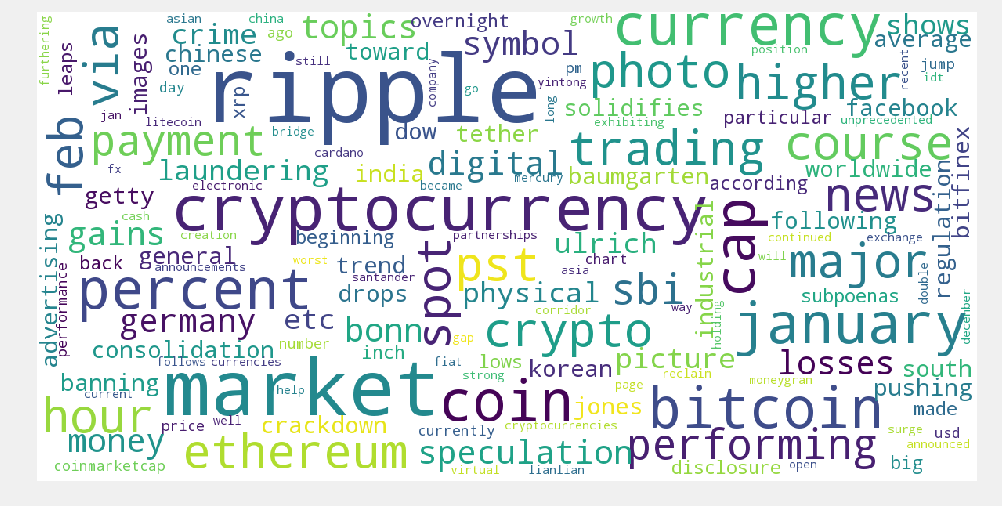

In [66]:
sentiment_analysis(df.Text[0]).words_only().word_cloud()

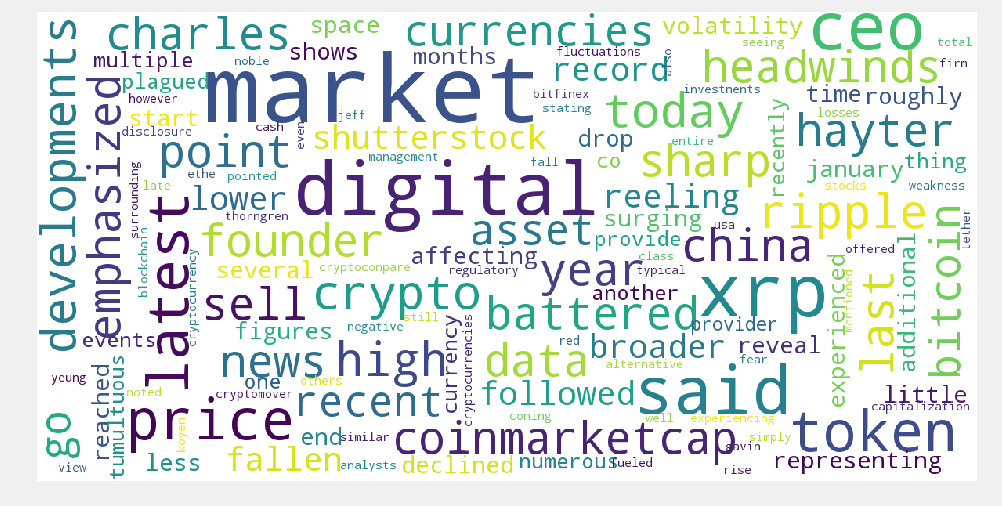

In [67]:
sentiment_analysis(df.Text[28]).words_only().word_cloud()

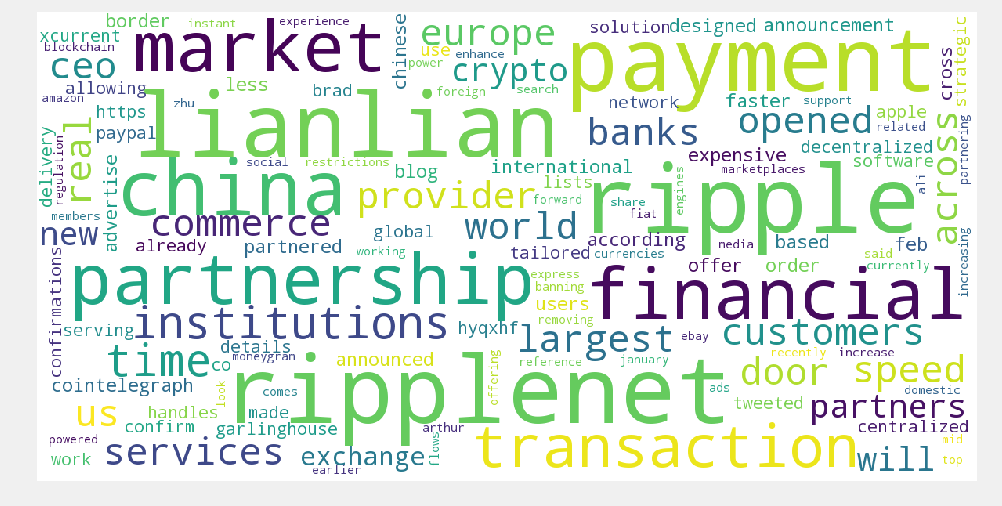

In [68]:
sentiment_analysis(df.Text[92]).words_only().word_cloud()